In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd /content/drive/My Drive/FinalProject
IMAGE_PATH='images/'

/content/drive/.shortcut-targets-by-id/1bXi9uXJlRd3MyzEZQERAL3lIrx8FkT26/FinalProject


# Blackbox Approach

|||
|:-:|:-:|
| <img width="300" src="https://drive.google.com/uc?export=view&id=1dkuATBulxnuQ_brLnf-F5bps1n24U4xw" /> | <h3>Derivative of functions</h3>$\dot{x}(t) = f(x(t), t)$ <br /> $\dot{x}(t)$ is the time derivative of the unknown function $x(t)$. The unknown function $x(t)$ that evaluates the state given time. <br /> Derivative function <b>f</b> is regarded as a black box. Given a numerical value <b>x</b> and <b>t</b>, the black box will return the time derivative of <b>x</b>. <br /><br /><h3>Calculate next step with explicit(forward) Euler integrator</h3>$\Delta{x} = f(x(t), t) \cdot \Delta{t}$<br />$ x_{i+1} = x_i + \Delta{x}$<br /> In other words, $x(t+\Delta{t}) = x(t) + \Delta{x}$, where <b>$\Delta{t}$</b> is small time and $t$ is the initial time.<br /><br /> <h3>Calculate next step with Runge Kutta $4^{th}$ order</h3> $k_1 = f(x(t), t) \cdot \Delta{t} \\ k_2 = f(x(t) + \frac{k_1}{2}, t + \frac{\Delta{t}}{2}) \cdot \Delta{t} \\ k_3 = f(x(t) + \frac{k_2}{2}, t + \frac{\Delta{t}}{2}) \cdot \Delta{t} \\ k4 = f(x(t) + k_3, t + \Delta{t}) \cdot \Delta{t} \\ x(t + \Delta{t}) = x(t) + \frac{k_1}{6} + \frac{k_2}{3} + \frac{k_3}{3} + \frac{k_4}{6} \\ $ |


# Bifurcation
Changes in the qualitative behavior of the dynamical system over changes of their <b>parameters</b> are called <b>bifurcations</b>. Parameters differ depending on a domain. i.e. • Desired speed for individuals • Distance to obstacles • Width of doors • Number of pedestrians in a room can be parameters in crowd dynamics.

In [3]:
%load_ext autoreload
%autoreload 2
!pip install pytorch-lightning==0.7.6 > /dev/null
import pytorch_lightning as pl
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import torch.nn.functional as F
import math
from scipy.integrate import solve_ivp

%matplotlib inline
#plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Generate data for training
We want to learn bifurcation given in Exercise 3.

$\dot{x_1} = \alpha x_1 - x_2 - x_1(x_1^2 + x_2^2)$, <br />
$\dot{x_2} = x_1 + \alpha x_2 - x_2(x_1^2 + x_2^2)$,
<br />
Therefore, we generate grand truth data for this dynamical system with $ scipy.integrate.solve_ivp$ for initial point $(0,2)$

In [20]:
ALPHA = 1
def calculate_next_state(t, x):
    """
    Hobf bifurcation for a=1

    Computes next state of given function based on the previous x value.

    :param t: One-dimensional independent variable (time)
    :param x: State of the function.
    :return: New state of the function.
    """
    v = [(x[0] - x[1] - x[0] * (x[0] ** 2 + x[1] ** 2)),
         (x[0] + x[1] - x[1] * (x[0] ** 2 + x[1] ** 2))]

    return v

In [ ]:
"""
dx / dt = f(t, x)
x(t0) = x0
"""
# Generate training data for 100 seconds starting from (2, 0)
end_time = 100
t = 0
x = [2, 0] # initial point
sol = solve_ivp(calculate_next_state, [t, t + end_time+1], np.array(x))
x_0 = sol.y[:,:-1].T
x_1 = sol.y[:,1:].T
ax = np.array([[ALPHA]*len(x_0)]).T
x_0_train = torch.from_numpy(np.append(x_0, ax, axis=1)).float()
x_1_train = torch.from_numpy(np.append(x_1, ax, axis=1)).float()

# Sampling a square of initial values
step_size = 0.1
axis = np.arange(-3,3,step_size)
x1, x2 = np.meshgrid(axis, axis)



# Generate validation data for 50 seconds starting from last point of training data.
end_time = 50
t = end_time
sol = solve_ivp(calculate_next_state, [t, t + end_time+1], np.array(x_1_train[-1][0:2]))
x_0 = sol.y[:,:-1].T
x_1 = sol.y[:,1:].T
ax = np.array([[ALPHA]*len(x_0)]).T
x_0_val = torch.from_numpy(np.append(x_0, ax, axis=1)).float()
x_1_val = torch.from_numpy(np.append(x_1, ax, axis=1)).float()

# Generate training data for 10 seconds with different alpha values
x = [2, 0]
end_time = 10000
t = 0
x_0_train_alphas = None
x_1_train_alphas = None
alphas = np.arange(-2, 2, 0.1)

# Obtain results for each alpha value
for a in alphas:
  ALPHA = a
  sol = solve_ivp(calculate_next_state, [t, t + end_time+1], np.array(x))
  x_0 = sol.y[:,:-1].T
  x_1 = sol.y[:,1:].T
  ax = np.array([[ALPHA]*len(x_0)]).T
  if x_0_train_alphas is None:
    x_0_train_alphas = np.append(x_0, ax, axis=1)
    x_1_train_alphas = np.append(x_1, ax, axis=1)
  else:
    x_0_train_alphas = np.concatenate((x_0_train_alphas, np.append(x_0, ax, axis=1)))
    x_1_train_alphas = np.concatenate((x_1_train_alphas, np.append(x_1, ax, axis=1)))

BIFURCATION_DATASET = np.append(x_0_train_alphas, x_1_train_alphas[:,:2], axis=1)

x_0_train_alphas = torch.from_numpy(x_0_train_alphas).float()
x_1_train_alphas = torch.from_numpy(x_1_train_alphas).float()

print("Number of points in train data: {}".format(x_0_train.shape))
print("Number of points in validation data: {}".format(x_0_val.shape))
print("Number of points in train data for different alpha values: {}".format(x_0_train_alphas.shape))

Number of points in train data: torch.Size([154, 3])
Number of points in validation data: torch.Size([77, 3])
Number of points in train data for different alpha values: torch.Size([401027, 3])


In [ ]:
big_data = x_0_train_alphas

In [ ]:
np.random.shuffle(big_data)
shuffled_data = big_data

In [ ]:
# Create train, validation and test datasets
arr_size = shuffled_data.shape[0]
print(arr_size)
block_size = math.floor(0.1 * arr_size)
print(block_size)
train_data = shuffled_data[:6*block_size] #%60 train
valid_data = shuffled_data[6*block_size:9*block_size]#%30 valid
test_data = shuffled_data[9*block_size:arr_size]#%10 test


401027
40102


In [ ]:
# Create batches
batch_num = math.floor(arr_size/64)
batched_train_data = np.array_split(train_data, batch_num)

In [ ]:
print(x_0_train_alphas)

tensor([[ 2.0000,  0.0000, -2.0000],
        [ 2.0000,  0.0000, -2.0000],
        [ 1.9364,  0.0106, -2.0000],
        ...,
        [ 0.5313,  1.2736,  1.9000],
        [-0.0881,  1.2649,  1.6000],
        [-0.2580,  0.8596,  0.8000]])


In [ ]:
class RungeKutta(nn.Module):
    def __init__(self, D, H):
        """
        y=xAT

        param D: dimension of X
        param H: hiddensize
        """
        super(RungeKutta, self).__init__()
        self.f_k1_in = nn.Linear(D, H, bias=False)
        self.f_k1_out = nn.Linear(H, D, bias=False)
        self.f_k2_in = nn.Linear(D, H, bias=False)
        self.f_k2_out = nn.Linear(H, D, bias=False)
        self.f_k3_in = nn.Linear(D, H, bias=False)
        self.f_k3_out = nn.Linear(H, D, bias=False)
        self.f_k4_in = nn.Linear(D, H, bias=False)
        self.f_k4_out = nn.Linear(H, D, bias=False)

    def forward(self, x_0, alpha, dt):
        """
        param x_0: (N,D) Initial points
        param t: Delta(t)
        """
        a = torch.from_numpy(np.array([alpha])).float()
        dt = (torch.from_numpy(np.ones_like(x_0.shape)) * dt)
        
        k1 = self.f_k1_out(F.relu(self.f_k1_in(x_0))) * dt # (N,H)
        k2 = self.f_k2_out(F.relu(self.f_k2_in(x_0))) * dt # (N,H)
        k3 = self.f_k3_out(F.relu(self.f_k3_in(x_0))) * dt # (N,H)
        k4 = self.f_k4_out(F.relu(self.f_k4_in(x_0))) * dt # (N,H)

        x_1 = x_0 + k1/6 + k2/3 + k3/3 + k4/6

        return x_1

In [5]:
class Eueler(nn.Module):
    def __init__(self, input_size=3, output_size=2, hidden_size = 10):
        """
        param D: dimension of state variable X
        param H: hiddensize
        """
        super(Eueler, self).__init__()
        self.M = input_size
        self.D = output_size
        self.H = hidden_size

        self.linear_input = nn.Linear(self.M, self.H)
        self.linear_hidden = nn.Linear(self.H, self.H)
        self.linear_output = nn.Linear(self.H, self.D)
        
    def forward(self, X, dt):
        """
        param X: (N,M) Initial points with correspoding operating parameters
        param t: Delta(t)
        """

        f = self.linear_input(X)
        for k in range(3):
          f = self.linear_hidden(F.relu(f))
        f = self.linear_output(f)
        
        x_1 = X[:,:D] + f * (torch.from_numpy(np.ones_like(f.shape)) * dt).to(device)

        return x_1

In [6]:
# https://pytorch.org/tutorials/beginner/pytorch_with_examples.html

### Run this block for Euler method, run the next one for Runge-Kutte method. Be careful and do not run both!
model = Eueler(2, 50).to(device)
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model = RungeKutta(2, 50)
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
###

In [ ]:
"""
TRAIN
"""
dt =  0.1
for t in range(5000):
    y_pred = model(x_0_train, dt) # ALPHA

    # Compute and print loss.
    loss = loss_fn(y_pred, x_1_train)
    if t % 100 == 0:
        print(t, loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

RuntimeError: ignored

In [ ]:
print(x_0_train.shape)

torch.Size([7445, 2])


In [ ]:
print(x_0_train_alphas.shape)

torch.Size([206567, 3])


In [ ]:
"""
TRAIN FOR DIFFERENT ALPHA VALUES
"""
dt =  0.1
for t, batch in enumerate(batched_train_data):
    y_pred = model(batch[:, :2], batch[:, 2:3], dt)

    # Compute and print loss.
    loss = loss_fn(y_pred, batch[:, :2])
    #if t % 1000 == 0:
    #    print(t, loss.item())
    print(loss.item())

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

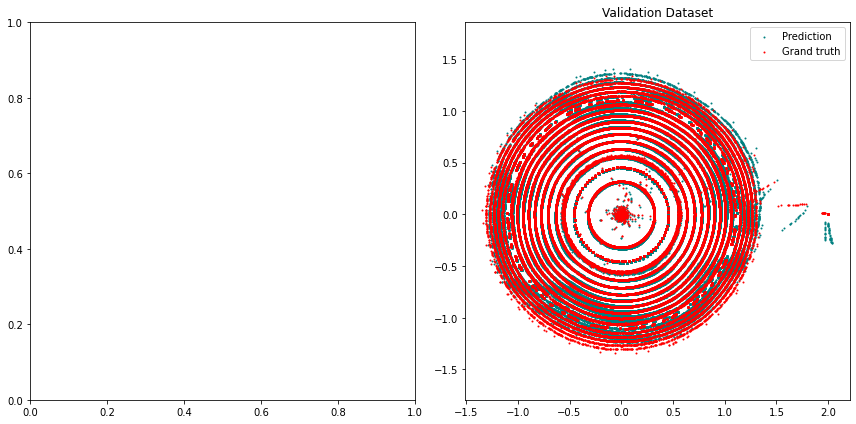

In [ ]:
"""
TODO: FIX 
"""
ALPHA = 1
dt = 0.1
#y_pred_on_train_set = model(train_data[:,:2], train_data[:,2:3], dt).detach().numpy()
y_pred_on_val_set = model(x_0_val[:,:2], x_0_val[:,2:3], dt).detach().numpy()

fig, axs = plt.subplots(1,2, figsize=(12,6))
#axs[0].scatter(y_pred_on_train_set[:,0], y_pred_on_train_set[:,1], linewidth=1, s=1, color="teal", label="Prediction")
#axs[0].scatter(train_data[:,0], train_data[:,1], linewidth=1, s=1, color="red", label="Grand truth")
#axs[0].set_title('Train Dataset')

axs[1].scatter(y_pred_on_val_set[:,0], y_pred_on_val_set[:,1], linewidth=1, s=1, color="teal", label="Prediction")
axs[1].scatter(valid_data[:,0], valid_data[:,1], linewidth=1, s=1, color="red", label="Grand truth")
axs[1].set_title('Validation Dataset')

plt.tight_layout()
plt.axis('equal')
plt.legend()
plt.show()

  

  

In [ ]:
"""
TEST FOR DIFFERENT alpha value
"""
ALPHA = 0

x = [2, 0]
t = 0
end_time = 50
sol = solve_ivp(calculate_next_state, [t, t + end_time+1], np.array(x))
x_0_val = torch.from_numpy(sol.y[:,:-1].T).float()
x_1_val = torch.from_numpy(sol.y[:,1:].T).float()

dt = 0.1
y_pred_on_val_set = model(x_0_val, ALPHA, dt).detach().numpy()

fig, axs = plt.subplots(1,2, figsize=(12, 6))
axs[0].scatter(y_pred_on_val_set[:,0], y_pred_on_val_set[:,1], linewidth=1, s=1, color="teal")
axs[0].set_title('Prediction')
axs[1].scatter(x_1_val[:,0], x_1_val[:,1], linewidth=1, s=1, color="red")
axs[1].set_title('Grand truth')

fig.suptitle('Prediction for ALPHA = {}'.format(ALPHA))
plt.show()

NameError: ignored

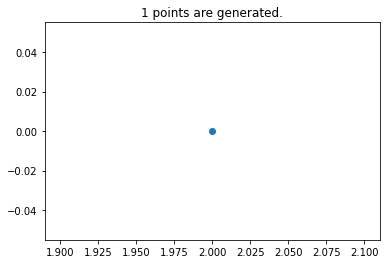

(154) points are generated for alpha value (1.0)
There are torch.Size([154, 5]) data sample


In [54]:
device = torch.device("cpu")

# TODO: Sample points from a 3D dimensional uniform dataset
NUM_POINTS = 1
x = [2] #np.random.uniform(-2,2, NUM_POINTS)
y = [0] #np.random.uniform(-2,2, NUM_POINTS)
alphas = np.array([1.0]) #np.arange(-2, 2.1, 0.1)

fig, ax = plt.subplots()
ax.scatter(x, y)
ax.set_title("{} points are generated.".format(NUM_POINTS))
plt.show()

x_0_train_alphas = None
x_1_train_alphas = None

point_num = 0
for alpha in alphas:
  for i,j in tuple(zip(x,y)):
    t = 0
    end_time = 100
    
    sol = solve_ivp(calculate_next_state, [t, t + end_time+1], np.array([i, j]))
    x_0 = torch.from_numpy(sol.y[:,:-1].T).to(device)
    x_1 = torch.from_numpy(sol.y[:,1:].T).to(device)
    ax = torch.from_numpy(np.array([[alpha]*len(x_0)]).T).to(device)
    
    if x_0_train_alphas is None:
      x_0_train_alphas = torch.cat([x_0, ax], dim=1).to(device)
      x_1_train_alphas = torch.cat([x_1, ax], dim=1).to(device)
    else:
      x_0_train_alphas = torch.cat([x_0_train_alphas, torch.cat([x_0, ax], dim=1).to(device)], dim=0)
      x_1_train_alphas = torch.cat([x_1_train_alphas, torch.cat([x_1, ax], dim=1).to(device)], dim=0)
  print("({}) points are generated for alpha value ({})".format(len(x_1_train_alphas)-point_num, alpha))
  point_num = len(x_1_train_alphas)

BIFURCATION_DATASET = torch.cat([x_0_train_alphas, x_1_train_alphas[:,:2]], dim=1)
print("There are {} data sample".format(BIFURCATION_DATASET.size()))
torch.save(BIFURCATION_DATASET, 'BIFURCATION_DATASET_n_250_dt_100.pt')

0# x0: tensor([2., 0.], dtype=torch.float64) x1: tensor([1.9970e+00, 9.9800e-04], dtype=torch.float64) y: tensor([2.0000e+00, 0.0000e+00, 1.0000e+00, 1.9970e+00, 9.9800e-04],
       dtype=torch.float64) 
1# x0: tensor([1.9970e+00, 9.9800e-04], dtype=torch.float64) x1: tensor([1.9680, 0.0108], dtype=torch.float64) y: tensor([1.9970e+00, 9.9800e-04, 1.0000e+00, 1.9680e+00, 1.0818e-02],
       dtype=torch.float64) 
2# x0: tensor([1.9680, 0.0108], dtype=torch.float64) x1: tensor([1.7414, 0.0967], dtype=torch.float64) y: tensor([1.9680, 0.0108, 1.0000, 1.7414, 0.0967], dtype=torch.float64) 
3# x0: tensor([1.7414, 0.0967], dtype=torch.float64) x1: tensor([1.4057, 0.2723], dtype=torch.float64) y: tensor([1.7414, 0.0967, 1.0000, 1.4057, 0.2723], dtype=torch.float64) 
4# x0: tensor([1.4057, 0.2723], dtype=torch.float64) x1: tensor([1.1256, 0.4840], dtype=torch.float64) y: tensor([1.4057, 0.2723, 1.0000, 1.1256, 0.4840], dtype=torch.float64) 
5# x0: tensor([1.1256, 0.4840], dtype=torch.float64) 

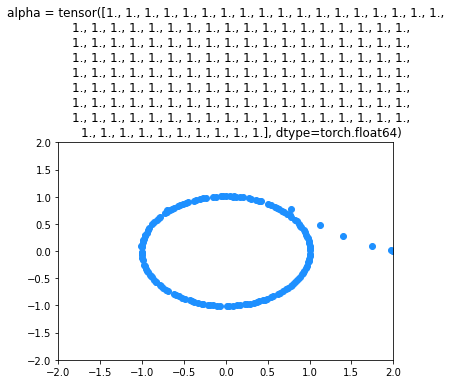

In [55]:
# BIFURCATION_DATASET NX3

x_0 = BIFURCATION_DATASET[:,:2]
alpha = BIFURCATION_DATASET[:,2]
x_1 = BIFURCATION_DATASET[:,3:]
for i in range(len(x_0)):
  print("{}# x0: {} x1: {} y: {} ".format(i, x_0[i], x_1[i], BIFURCATION_DATASET[i]))

fig, ax = plt.subplots()
ax.scatter(x_0[:,0], x_0[:,1], color='dodgerblue', linewidth=1)
ax.set_title("alpha = {}".format(alpha))
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.show()

In [ ]:
# LOAD FROM DATASET. data is generated in cuda from. use "map_location=torch.device('cpu')" if you want to load into cpu
BIFURCATION_DATASET = torch.load('BIFURCATION_DATASET_n_250_dt_100.pt', map_location=torch.device('cpu'))
# TO WORK ON CPU
#BIFURCATION_DATASET = BIFURCATION_DATASET.to('cpu')

In [58]:
"""
FULL TRAININ PROCEDURE
ASSUME WE HAVE `BIFURCATION_DATASET`
ALL OTHER OPERATIONS WILL BE DONE IN THIS BLOCK FOR TRAINING
"""
import time
device = torch.device("cpu")
print(device)
print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
N = len(BIFURCATION_DATASET) # Size of dataset
M=3 # Dimension of initial dataset
D=2
H=100
model = Eueler(M, D, H).to(device)
loss_fn = nn.MSELoss()

learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


num_train, num_val, num_test = int(N * 0.6), int(N * 0.3), int(N * 0.1)

np.random.seed(0)
indices = np.random.permutation(N)
train_idx, val_idx, test_idx = indices[:num_train], indices[num_train:num_train + num_val], indices[num_train + num_val:]
#print("BIFURCATION_DATASET.shape {}".format(BIFURCATION_DATASET.shape))
batch_size = 32
batch_num = math.floor(N/batch_size)
#print("train_idx {}".format(train_idx))
batched_train_idxs = np.array_split(train_idx, batch_num)
#print("batched_train_idxs.shape {}".format(batched_train_idxs))
X = BIFURCATION_DATASET[:,:M]
X_1 = BIFURCATION_DATASET[:,M:]

dt = torch.tensor(0.1).to(device).float()
epochs = 1000
for t in range(epochs):
  train_epoch_loss = 0.0
  seconds = time.time()
  for batch_idx in batched_train_idxs:
    x_0_with_alpha = X[batch_idx].float()
    x_1 = X_1[batch_idx].float()

    y_pred = model(x_0_with_alpha, dt) # NxM => NxD

    # Compute and print loss.
    loss = loss_fn(y_pred, x_1)
    train_epoch_loss += loss

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()
  train_epoch_loss /= len(train_idx)
  validation_loss = loss_fn(model(X[val_idx].float(), dt), X_1[val_idx].float())
  print('(Epoch %d / %d, seconds: %d) train loss: %f validation loss: %f' % (t + 1, epochs, (time.time()-seconds), train_epoch_loss, validation_loss))
    

cpu
BIFURCATION_DATASET.shape torch.Size([154, 5])
(Epoch 1 / 1000, seconds: 0) train loss: 0.009531 validation loss: 0.204660
(Epoch 2 / 1000, seconds: 0) train loss: 0.009516 validation loss: 0.204366
(Epoch 3 / 1000, seconds: 0) train loss: 0.009501 validation loss: 0.204067
(Epoch 4 / 1000, seconds: 0) train loss: 0.009486 validation loss: 0.203764
(Epoch 5 / 1000, seconds: 0) train loss: 0.009471 validation loss: 0.203454
(Epoch 6 / 1000, seconds: 0) train loss: 0.009456 validation loss: 0.203133
(Epoch 7 / 1000, seconds: 0) train loss: 0.009440 validation loss: 0.202797
(Epoch 8 / 1000, seconds: 0) train loss: 0.009423 validation loss: 0.202441
(Epoch 9 / 1000, seconds: 0) train loss: 0.009405 validation loss: 0.202060
(Epoch 10 / 1000, seconds: 0) train loss: 0.009386 validation loss: 0.201653
(Epoch 11 / 1000, seconds: 0) train loss: 0.009365 validation loss: 0.201219
(Epoch 12 / 1000, seconds: 0) train loss: 0.009344 validation loss: 0.200755
(Epoch 13 / 1000, seconds: 0) trai

In [70]:
def get_next_state(t, x):
    v = calculate_next_state(t, x)

    x_new = [t * v[0] + x[0], t * v[1] + x[1]]

    return x_new

time_step = 0.001
points = []
time = 0
end_time = 10
x=[2, 0]
torch_x = torch.from_numpy(np.array([2, 0, 1]).reshape(1, 3))
print(torch_x.size())
torch_time_step = torch.tensor(0.001).to(device).float()
while time < end_time:
    #x = get_next_state(t=time_step, x=x)
    torch_x = model(torch_x.float(), torch_time_step)
    points.append(torch_x.detach().numpy())
    time += time_step

D = np.array(points)

fig, ax = plt.subplots()
ax.scatter(D[:,0], D[:,1], color='dodgerblue', linewidth=1)
ax.set_title("alpha = {}".format(alpha))
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.show()

torch.Size([1, 3])


TypeError: ignored

x_0: (14, 2), x_1: (14, 2)
x_0_train: torch.Size([14, 3]), x_1_train: torch.Size([14, 3])
0# y: [2. 0.] x0: tensor([2., 0., 1.]) x1: tensor([1.9970e+00, 9.9800e-04, 1.0000e+00])
1# y: [1.99700947e+00 9.98004694e-04] x0: tensor([1.9970e+00, 9.9800e-04, 1.0000e+00]) x1: tensor([1.9680, 0.0108, 1.0000])
2# y: [1.96795302 0.01081843] x0: tensor([1.9680, 0.0108, 1.0000]) x1: tensor([1.7414, 0.0967, 1.0000])
3# y: [1.74139098 0.0966962 ] x0: tensor([1.7414, 0.0967, 1.0000]) x1: tensor([1.4057, 0.2723, 1.0000])
4# y: [1.40569638 0.27232938] x0: tensor([1.4057, 0.2723, 1.0000]) x1: tensor([1.1256, 0.4840, 1.0000])
5# y: [1.1255779  0.48399676] x0: tensor([1.1256, 0.4840, 1.0000]) x1: tensor([0.7730, 0.7677, 1.0000])
6# y: [0.77304835 0.76770843] x0: tensor([0.7730, 0.7677, 1.0000]) x1: tensor([0.0954, 1.0215, 1.0000])
7# y: [0.09536734 1.02152481] x0: tensor([0.0954, 1.0215, 1.0000]) x1: tensor([-0.6996,  0.7498,  1.0000])
8# y: [-0.69963455  0.74979   ] x0: tensor([-0.6996,  0.7498,  1.0000])

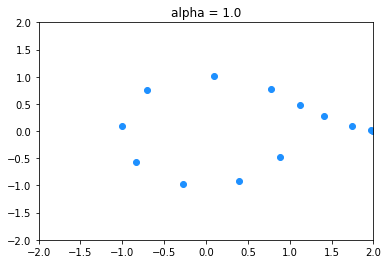

In [34]:
end_time = 5
t = 0
x = [2, 0] # initial point
sol = solve_ivp(calculate_next_state, [t, t + end_time+1], np.array(x))
x_0 = sol.y[:,:-1].T
x_1 = sol.y[:,1:].T
ax = np.array([[ALPHA]*len(x_0)]).T
x_0_train = torch.from_numpy(np.append(x_0, ax, axis=1)).float()
x_1_train = torch.from_numpy(np.append(x_1, ax, axis=1)).float()

print("x_0: {}, x_1: {}".format(x_0.shape, x_1.shape))
print("x_0_train: {}, x_1_train: {}".format(x_0_train.shape, x_1_train.shape))

for i in range(len(x_0)):
  print("{}# y: {} x0: {} x1: {}".format(i, sol.y.T[i], x_0_train[i], x_1_train[i]))
print(sol.y.T[len(sol.y.T)-1])

fig, ax = plt.subplots()
ax.scatter(x_0[:,0], x_0[:,1], color='dodgerblue', linewidth=1)
ax.set_title("alpha = {}".format(alpha))
ax.set_xlim([-2,2])
ax.set_ylim([-2,2])
plt.show()

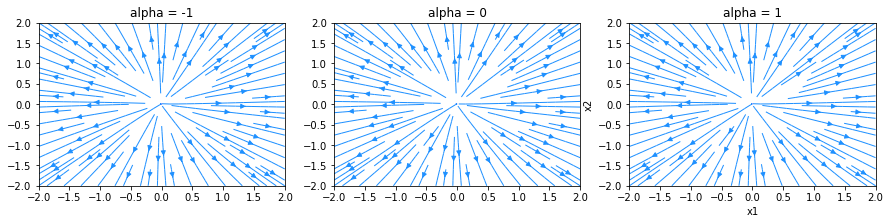

In [16]:
def get_predictions(alpha):
  x = np.arange(-2, 2.01, 0.01)
  x1, x2 = np.meshgrid(x, x)
  X_0 = np.vstack((x1.flatten(), x2.flatten())).T

  A = np.array([[alpha]*len(X_0)]).T
  X = np.append(X_0, A, axis=1)
  X = torch.from_numpy(X).float().to(device) # use np.column_stack([X_0, alpha]) instead

  dt = torch.tensor(0.1).to(device).float()
  y_pred = model(X, dt).cpu().detach().numpy()
  y1 = y_pred[:,0].reshape(x1.shape)
  y2 = y_pred[:,1].reshape(x2.shape)

  return (x1, x2, y1, y2)

def plot_phase_portrait(ax, pred, alpha):
  ax.streamplot(*pred, color='dodgerblue', linewidth=1)
  ax.set_title("alpha = {}".format(alpha))
  ax.set_xlim([-2,2])
  ax.set_ylim([-2,2])

alphas = [-1, 0, 1]
fig, axs = plt.subplots(1,len(alphas), figsize=(15,3))

for i, a in enumerate(alphas):
  pred = get_predictions(a)
  plot_phase_portrait(axs[i], pred, a)

plt.xlabel("x1")
plt.ylabel("x2")
plt.show()


<img width="800" src="https://drive.google.com/uc?export=view&id=18_ENcBvsKo2FYW1OIYws_bI_aD3LcbHx" />

- We know function f
  - f
- Neural ODE
